In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
pd.set_option('display.float_format', '{:.2f}'.format)## adios notacion cientifica 
import seaborn as sns 
%matplotlib inline
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets.samples_generator import make_blobs
from sklearn.preprocessing import StandardScaler
 
import sklearn.cluster as cluster
import time 
#sns.set_context('poster')
sns.set_color_codes()
plot_kwds = {'alpha' : 0.25, 's' : 80, 'linewidths':0}

%matplotlib inline

## Funciones 

In [10]:
'''
Recibe la fraccion que se va a cargar del set de datos 
Por defecto se carga el 0.01 %   
'''
def CargaDatos(frac=0.01):
    data = pd.read_csv("segmentacion_clientes.csv" , delimiter=";" , decimal="," , encoding='utf-8')
    ## muestra aleatorea de los datos 
    data = data.sample(frac=0.01 , random_state=42)
    return data

def Correlograma(data):
    sns.pairplot(data) 
    rows = str(data.shape[0])
    #save plot
    plt.savefig('plots/'+ 'coor.png')
    

'''
Grafica de puntos con una reg lin 
    Scatter( df , 'QUEJAS' , 'RECLAMOS' , xlim_a=0 ,xlim_b=1 , ylim_a=0, ylim_b=1  )
'''
def Scatter2(data  , x_name , y_name , xlim_a=None, xlim_b=None, ylim_a=None, ylim_b=None ):
    g = sns.lmplot(data = data , x = x_name, y =y_name  , line_kws={'color': 'red'})
    g.set(xlim=(xlim_a, xlim_b), ylim=(ylim_a, ylim_b))
    
'''
 Grafica scatter con el nombre de 2 columnas de un Dataframe
 parametros opcionales :
     limites de los ejes X ,Y 
     formato plano evita la notacion cientifica 
     si no se envian los parametros de los limites de grafica a tamaño max 
 
 Ejemplo : Scatter(df , 'PRODUCT_ID' , 'FACTURACION_PROMEDIO', ylim_a=1000, ylim_b=75000 )

''' 
def Scatter(df,  x_name, y_name, xlim_a=None, xlim_b=None, ylim_a=None, ylim_b=None):

    plt.rcParams['figure.dpi'] = 150  # BIG PLOT
    plt.ticklabel_format(useOffset=False, style='plain')

    plt.scatter(df[[x_name]], df[[y_name]], s=0.01) 

    plt.title('Scatterplot')
    plt.xlabel(x_name)
    plt.ylabel(y_name)
    plt.xlim(xlim_a, xlim_b)
    plt.ylim(ylim_a, ylim_b)

    #save plot
    plt.savefig('plots/'+'scatter '+x_name+'_'+y_name+".png")

    
    
'''
Grafica los clusters dado 2 columnas de datos de un df 
 Parametros opcionales :
     limites de los ejes X ,Y 
     formato plano evita la notacion cientifica 
     si no se envian los parametros de los limites de grafica a tamaño max 
 
 Ejemplo :DBSCAN_PLOT( df  , 90 , 88 ,  'SALDO_PROMEDIO' , 'ROTACION_CARTERA' , xlim_a=0 , xlim_b=50000 , ylim_a=0 , ylim_b=2  )
'''


def DBSCAN_PLOT(df, eps, min_samples, x_name, y_name, xlim_a=None, xlim_b=None, ylim_a=None, ylim_b=None):

    # Tranforma los datos a numpy array
    X = np.asarray(df[[x_name, y_name]])

    # crea el modelo
    dbscan_model = DBSCAN(eps=eps,  min_samples=min_samples).fit(X)

    # crea un verctor de boleanos con los labesl
    core_samples_mask = np.zeros_like(dbscan_model.labels_, dtype=bool)

    # vector de indices ? where 1
    core_samples_mask[dbscan_model.core_sample_indices_] = True

    labels = dbscan_model.labels_

    # Number of clusters in labels, ignoring noise if present.
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    #n_noise_ = list(labels).count(-1)

    # #############################################################################
    # Plot result

    plt.rcParams['figure.dpi'] = 150  # BIG PLOT
    plt.ticklabel_format(useOffset=False, style='plain')  # AVOID SCY NOT

    # Black removed and is used for noise instead.
    unique_labels = set(labels)
    colors = [plt.cm.Spectral(each)
              for each in np.linspace(0, 1, len(unique_labels))]
    for k, col in zip(unique_labels, colors):
        if k == -1:
            # Black used for noise.
            col = [0, 0, 0, 1]

        class_member_mask = (labels == k)

        xy = X[class_member_mask & core_samples_mask]
        plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
                 markeredgecolor='none', markersize=1.5)

        xy = X[class_member_mask & ~core_samples_mask]
        plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
                 markeredgecolor='none', markersize=0.6)

    plt.title('DBSCAN clusters~ %d' % n_clusters_ + '\n eps:%d ' %
              eps + ' min_samples:%d' % min_samples)
     
    plt.xlabel(x_name)
    plt.ylabel(y_name)
    
    plt.xlim(xlim_a, xlim_b)
    plt.ylim(ylim_a, ylim_b)
    
    #save plot
    plt.savefig('plots/'+'dbscan '+x_name+'_'+y_name+' c'+str(n_clusters_)+' e'+str(eps)+' m'+str(min_samples)+".png")

    plt.show()
    
      

def kNNPlot(df , x_name, y_name,  k ):
    from sklearn.neighbors import NearestNeighbors
    df = df[[x_name, y_name]]
    
    nbrs = NearestNeighbors(n_neighbors=k).fit(df)
    distances, indices = nbrs.kneighbors(df)
    
    # invierte el orden para presentacion 
    distanceDec = sorted(distances[:,k-1], reverse=False)
    #plt.plot(indices[:,0], distanceDec  )
    
    max_rows = df.shape[0] 
    
    plt.plot(list(range(1,max_rows+1)), distanceDec) 
    
    plt.title('eps Óptimo para DBSCAN ')
    plt.xlabel('numrows')
    plt.ylabel('nkk (%d ) Distancias'%k )

    # plotea al maximo de filas 
    plt.xlim(0, max_rows)
    # la media de las distancias ( revisar en dataset pequeños )
    plt.ylim(0, np.mean(distanceDec) )#200 
     
    #save plot
    plt.savefig('plots/'+'knn '+x_name+'_'+y_name+".png")
     
    
#kNNPlot(df , 'QUEJAS' , 'RECLAMOS' , k=50)

In [11]:
data = CargaDatos()

df = data # por seguridad 

## Se eliminan Productos outlier    
df = df[df.PRODUCT_ID > 0] 

## Convertimos las variables categoricas  
df["COMUNA"]       = df["COMUNA"].astype('category')
df["TIPO_REPARTO"] = df["TIPO_REPARTO"].astype('category')
df["TI"]           = df["TI"].astype('category')
df["TI2"]          = df["TI2"].astype('category')

# luego la encodificamos 
df["COMUNA_ENC"] = df["COMUNA"].cat.codes 

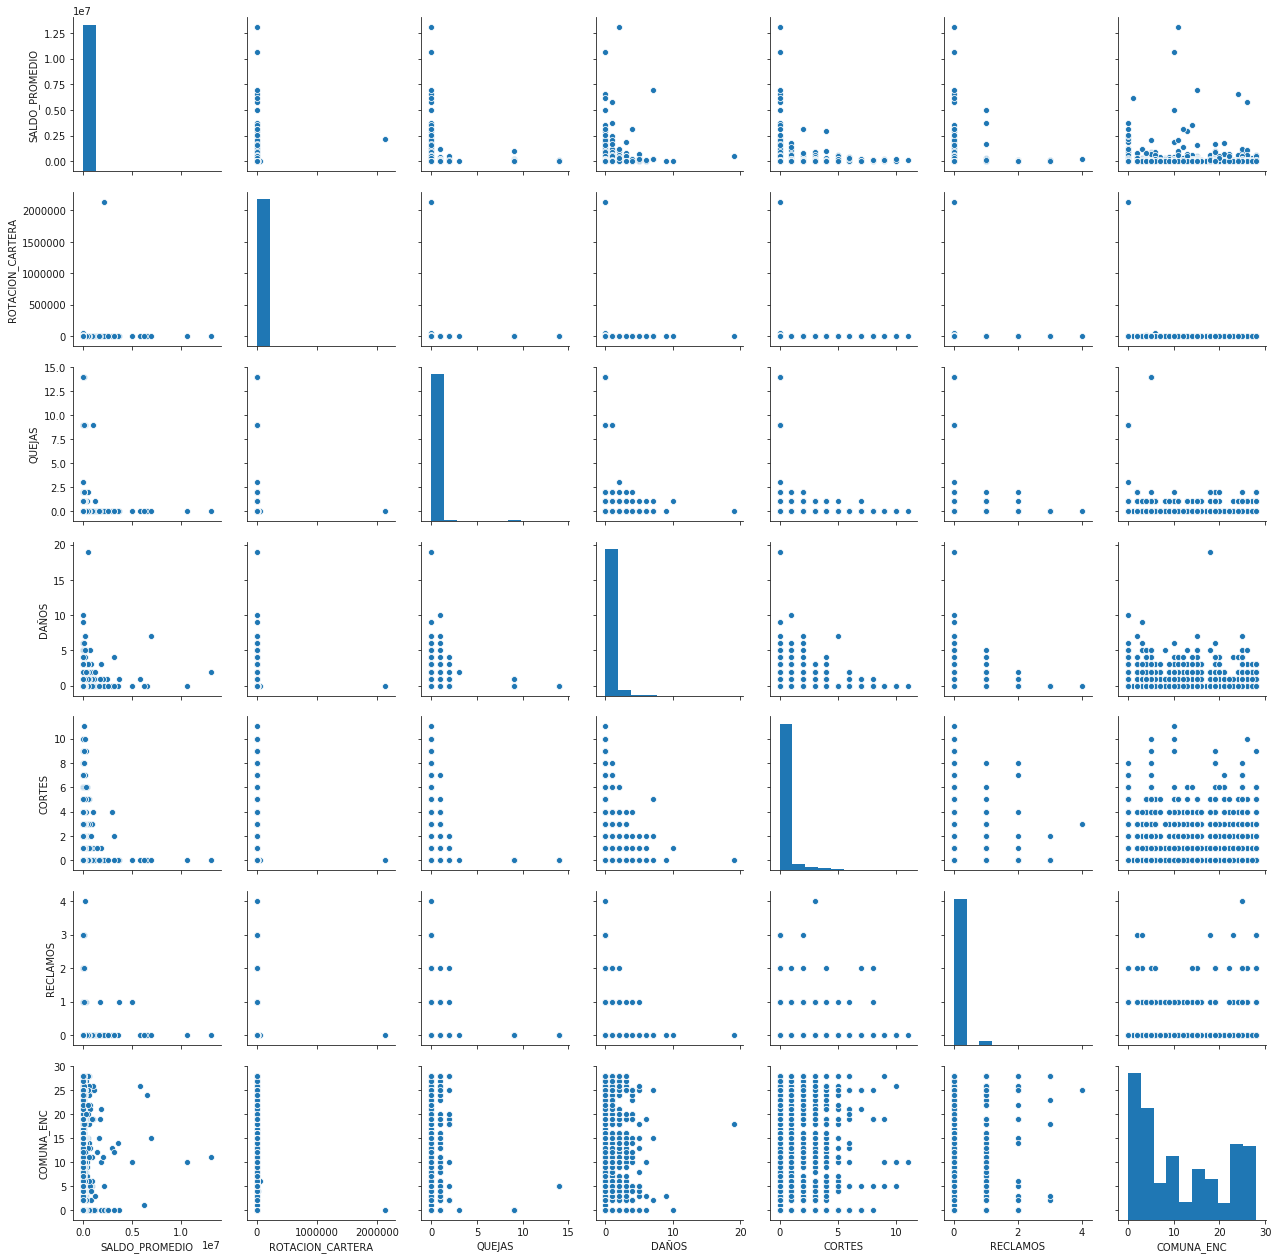

In [35]:
Correlograma(df[['SALDO_PROMEDIO' , 'ROTACION_CARTERA' , 'QUEJAS', 'DAÑOS', 'CORTES', 'RECLAMOS' , 'COMUNA_ENC']])

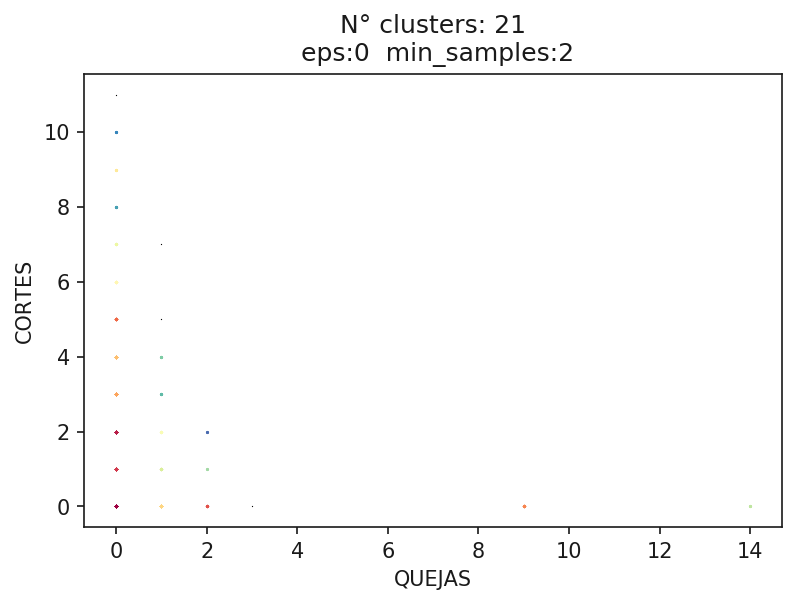

In [4]:
 DBSCAN_PLOT( df  , 0.5 , 2 ,  'QUEJAS' , 'CORTES'   )

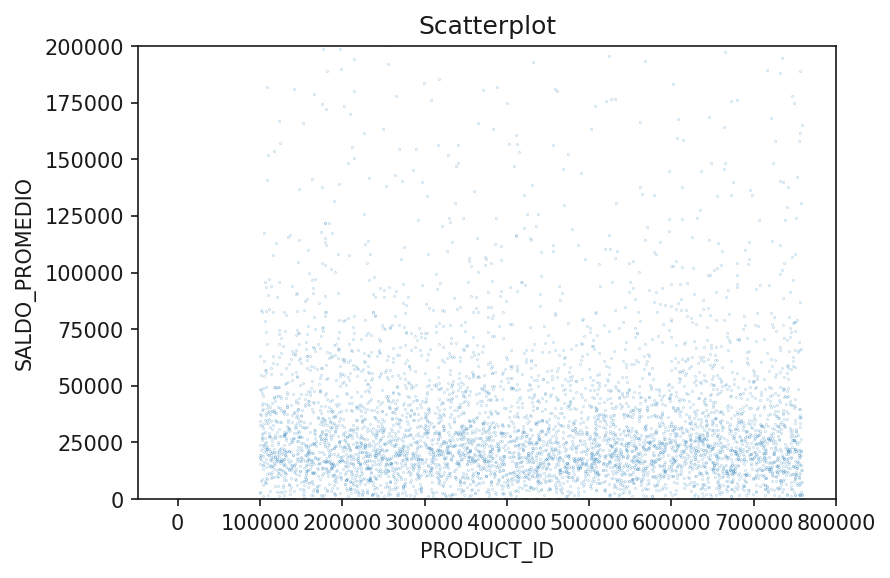

In [5]:
Scatter( df , 'PRODUCT_ID' , 'SALDO_PROMEDIO' , xlim_b=800000  ,    ylim_a=0, ylim_b=200000)

C:\Users\cvargasa\AppData\Local\conda\conda\envs\cnn\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


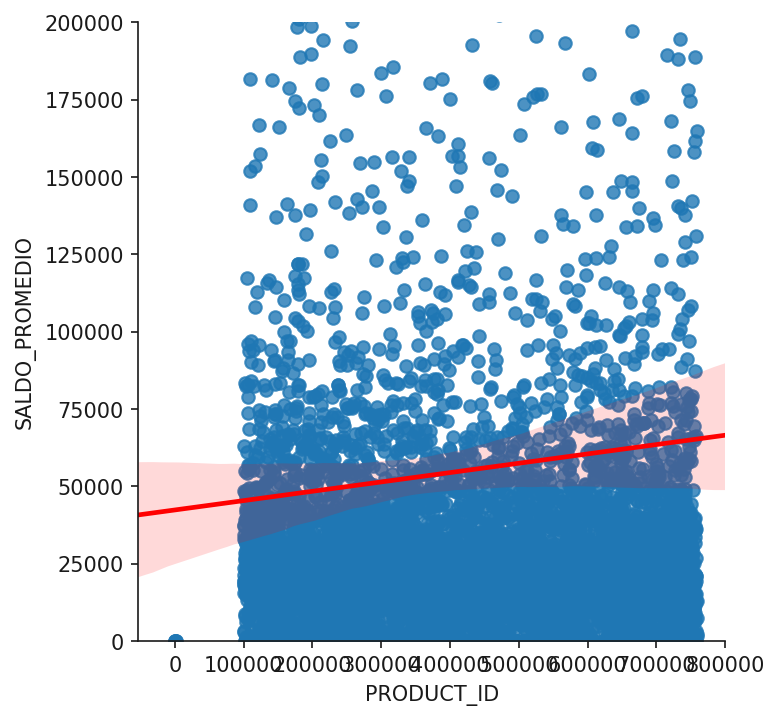

In [6]:
Scatter2( df , 'PRODUCT_ID' , 'SALDO_PROMEDIO' , xlim_b=800000  ,    ylim_a=0, ylim_b=200000)

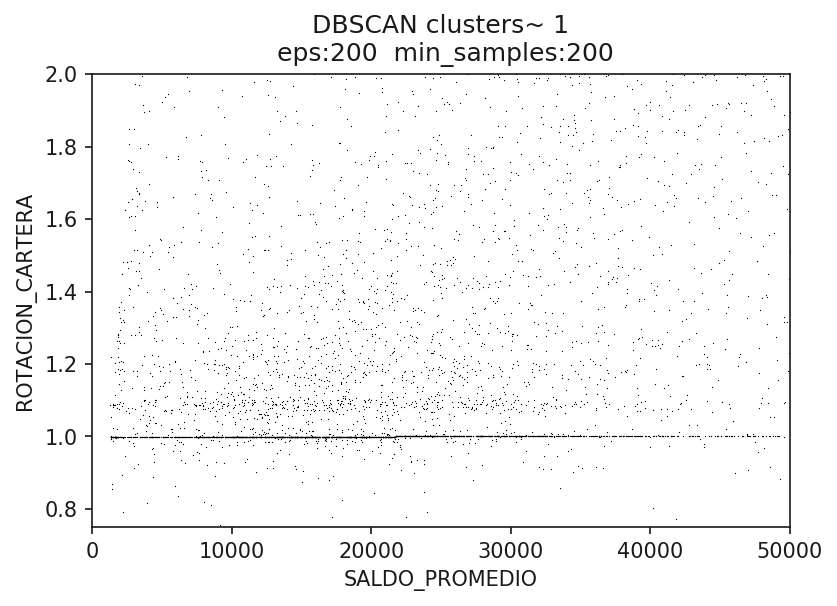

In [15]:
DBSCAN_PLOT( df  , 200 , 200 ,  'SALDO_PROMEDIO' , 'ROTACION_CARTERA' , xlim_a=0 , xlim_b=50000 , ylim_a=0.75 , ylim_b=2  )

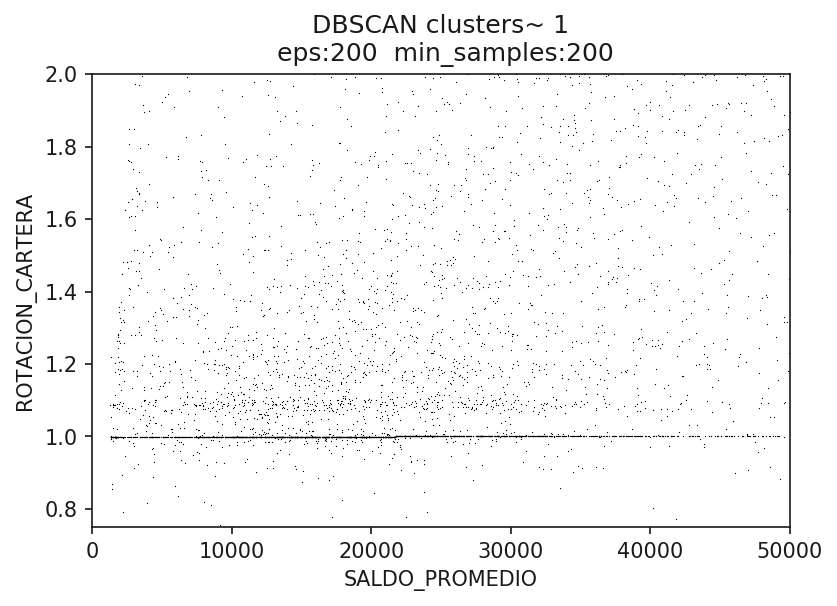

In [12]:
DBSCAN_PLOT( df  , 200 , 200 ,  'SALDO_PROMEDIO' , 'ROTACION_CARTERA' , xlim_a=0 , xlim_b=50000 , ylim_a=0.75 , ylim_b=2  )

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6313 entries, 489930 to 438113
Data columns (total 15 columns):
PRODUCT_ID              6313 non-null int64
SUBSCRIPTION_ID         6313 non-null int64
SUBSCRIBER_ID           6313 non-null int64
COMUNA                  6313 non-null category
TI                      6313 non-null category
TI2                     6313 non-null category
TIPO_REPARTO            6313 non-null category
QUEJAS                  6313 non-null int64
DAÑOS                   6313 non-null int64
CORTES                  6313 non-null int64
RECLAMOS                6313 non-null int64
FACTURACION_PROMEDIO    6313 non-null float64
SALDO_PROMEDIO          6313 non-null float64
ROTACION_CARTERA        6313 non-null float64
COMUNA_ENC              6313 non-null int8
dtypes: category(4), float64(3), int64(7), int8(1)
memory usage: 575.1 KB


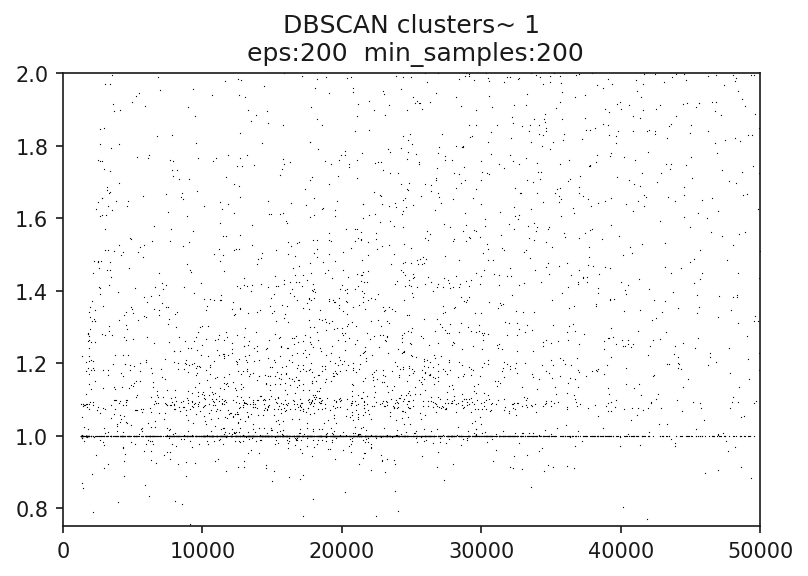

In [21]:
    
    
    # Tranforma los datos a numpy array
    X = np.asarray(df[['SALDO_PROMEDIO' , 'ROTACION_CARTERA']] )

    # crea el modelo
    dbscan_model = DBSCAN(eps=200,  min_samples=200).fit(X)

    # crea un verctor de boleanos con los labesl
    core_samples_mask = np.zeros_like(dbscan_model.labels_, dtype=bool)

    # vector de indices ? where 1
    core_samples_mask[dbscan_model.core_sample_indices_] = True

    labels = dbscan_model.labels_

    # Number of clusters in labels, ignoring noise if present.
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    #n_noise_ = list(labels).count(-1)

    # #############################################################################
    # Plot result

    plt.rcParams['figure.dpi'] = 150  # BIG PLOT
    plt.ticklabel_format(useOffset=False, style='plain')  # AVOID SCY NOT

    # Black removed and is used for noise instead.
    unique_labels = set(labels)
    colors = [plt.cm.Spectral(each)
              for each in np.linspace(0, 1, len(unique_labels))]
    for k, col in zip(unique_labels, colors):
        if k == -1:
            # Black used for noise.
            col = [0, 0, 0, 1]

        class_member_mask = (labels == k)

        xy = X[class_member_mask & core_samples_mask]
        plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
                 markeredgecolor='none', markersize=1.5)

        xy = X[class_member_mask & ~core_samples_mask]
        plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
                 markeredgecolor='none', markersize=0.6)

    plt.title('DBSCAN clusters~ %d' % n_clusters_ + '\n eps:%d ' %
              200 + ' min_samples:%d' % 200)
     
    xlim_a=0 
    xlim_b=50000 
    ylim_a=0.75 
    ylim_b=2 
 
 
    plt.xlim(xlim_a, xlim_b)
    plt.ylim(ylim_a, ylim_b)
   
    plt.show()
    

In [16]:
df[['SALDO_PROMEDIO' , 'ROTACION_CARTERA']] 

,SALDO_PROMEDIO,ROTACION_CARTERA
489930,15230.18,1.44
533353,33133.00,1.00
222775,0.00,0.00
413517,21314.09,1.00
267704,39170.18,1.27
408472,1490.18,1.00
484787,32284.27,1.76
626077,12444.55,1.00
346095,23356.50,1.53
404250,28169.80,1.93
